<a href="https://colab.research.google.com/github/btcnhung1299/tf-practice/blob/master/IMG_CatVsDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q Pillow

In [2]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Data gathering

In [3]:
!wget -q https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
!unzip -q cats_and_dogs_filtered.zip

In [4]:
TRAIN_DIR = "./cats_and_dogs_filtered/train"
VAL_DIR = "./cats_and_dogs_filtered/validation"

Inspect samples from datasets.

Image shape: (499, 500, 3)
Pixel in range: 0 255


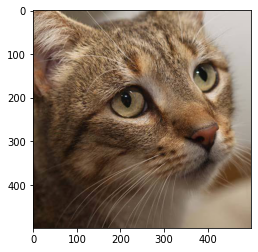

In [5]:
sample_idx = 0
label = "cats"
train_sample_fn = os.listdir(os.path.join(TRAIN_DIR, label))[sample_idx]
train_sample_path = os.path.join(TRAIN_DIR, label, train_sample_fn)

img = Image.open(train_sample_path)
img_data = np.asarray(img)

print("Image shape:", img_data.shape)
print("Pixel in range:", np.min(img_data), np.max(img_data))
plt.imshow(img_data);

**Create TF datasets** (with data augmentation in training)

In [6]:
IMG_SIZE = (224, 224)
INP_SHAPE = (*IMG_SIZE, 3)
BATCH_SIZE = 64

def gen_new_data(data_folder, augmented=True):
  if augmented:
    data_gen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                  width_shift_range=0.2, height_shift_range=0.2,
                                  horizontal_flip=True)
  else:
    data_gen = ImageDataGenerator(rescale=1./255)

  data = data_gen.flow_from_directory(
      data_folder,
      target_size=IMG_SIZE,
      batch_size=BATCH_SIZE,
      class_mode="binary",
  )
  return data

In [7]:
ds_train = gen_new_data(TRAIN_DIR, augmented=True)
ds_val = gen_new_data(VAL_DIR, augmented=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Transfer learning

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental.preprocessing import Resizing

### ResNet-50

The default size of input image is 224 x 224, but not fixed.

In [9]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4" 

resnet = Sequential()
resnet.add(Resizing(224, 224, input_shape=INP_SHAPE))
resnet.add(hub.KerasLayer(resnet_url, trainable=False))
resnet.add(Dense(1, activation="sigmoid"))
resnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1)                 2049      
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
resnet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [11]:
resnet_history = resnet.fit(ds_train, epochs=15, validation_data=ds_val)

Epoch 1/15
32/32 [==============================] - 29s 916ms/step - loss: 0.3154 - acc: 0.8665 - val_loss: 0.0944 - val_acc: 0.9760
Epoch 2/15
32/32 [==============================] - 28s 881ms/step - loss: 0.1062 - acc: 0.9650 - val_loss: 0.0561 - val_acc: 0.9810
Epoch 3/15
32/32 [==============================] - 28s 874ms/step - loss: 0.0705 - acc: 0.9755 - val_loss: 0.0467 - val_acc: 0.9830
Epoch 4/15
32/32 [==============================] - 28s 877ms/step - loss: 0.0613 - acc: 0.9775 - val_loss: 0.0306 - val_acc: 0.9890
Epoch 5/15
32/32 [==============================] - 28s 883ms/step - loss: 0.0630 - acc: 0.9720 - val_loss: 0.0285 - val_acc: 0.9900
Epoch 6/15
32/32 [==============================] - 29s 894ms/step - loss: 0.0591 - acc: 0.9765 - val_loss: 0.0269 - val_acc: 0.9900
Epoch 7/15
32/32 [==============================] - 28s 885ms/step - loss: 0.0436 - acc: 0.9825 - val_loss: 0.0260 - val_acc: 0.9890
Epoch 8/15
32/32 [==============================] - 28s 885ms/step - 

### MobileNetV2

Size of input image is 224 x 224, fixed.

In [12]:
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" 

mobilenet = Sequential()
mobilenet.add(Resizing(224, 224, input_shape=INP_SHAPE))
mobilenet.add(hub.KerasLayer(mobilenet_url, trainable=False))
mobilenet.add(Dense(1, activation="sigmoid"))
mobilenet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [13]:
mobilenet.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [14]:
mobilenet_history = mobilenet.fit(ds_train, epochs=20, validation_data=ds_val)

Epoch 1/20
32/32 [==============================] - 28s 887ms/step - loss: 0.2972 - acc: 0.8955 - val_loss: 0.1239 - val_acc: 0.9780
Epoch 2/20
32/32 [==============================] - 28s 864ms/step - loss: 0.1315 - acc: 0.9615 - val_loss: 0.0767 - val_acc: 0.9830
Epoch 3/20
32/32 [==============================] - 27s 858ms/step - loss: 0.0996 - acc: 0.9645 - val_loss: 0.0613 - val_acc: 0.9840
Epoch 4/20
32/32 [==============================] - 27s 858ms/step - loss: 0.0846 - acc: 0.9735 - val_loss: 0.0546 - val_acc: 0.9860
Epoch 5/20
32/32 [==============================] - 28s 866ms/step - loss: 0.0778 - acc: 0.9725 - val_loss: 0.0500 - val_acc: 0.9830
Epoch 6/20
32/32 [==============================] - 27s 850ms/step - loss: 0.0693 - acc: 0.9750 - val_loss: 0.0508 - val_acc: 0.9850
Epoch 7/20
32/32 [==============================] - 27s 853ms/step - loss: 0.0726 - acc: 0.9760 - val_loss: 0.0456 - val_acc: 0.9870
Epoch 8/20
32/32 [==============================] - 27s 859ms/step - 